In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pickle
import json
import torch
from tqdm import tqdm, tqdm_notebook
import os

from bullseye import BullseyeData
from mapping import *

# matplotlib and seaborn settings
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

sns.set_style("white")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14}

## Generate and Plot 2D Bullseye Data samples 

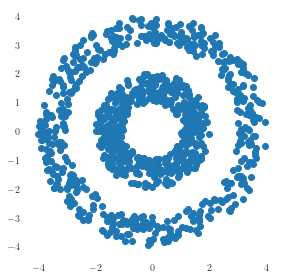

In [2]:
if not os.path.isdir("data"):
    os.mkdir("data")

# generate samples and save to file
datagen = BullseyeData(1000, 0.075, copies=1, scale_4=True)
datagen.make_X_data('data/bullseye2dX.h5')

# plot samples
fig,ax = plt.subplots(figsize=(4,4))
sns.despine(left=True, bottom=True)
ax.scatter(datagen.X[:,0], datagen.X[:,1])
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.set_xlabel(r" ", fontdict=font)
ax.set_ylabel(r" ", fontdict=font)
plt.tight_layout()
plt.savefig("assets/bullseye.pdf")
plt.show()

### 1. Learn Mappings of $X$ data for estimating $I(X;Y)$

### 1. learn mapping without the proposed information efficiency regularization

Validation performance didn't improve for 10 epochs. Training stops.


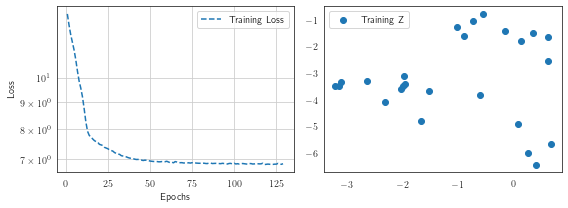

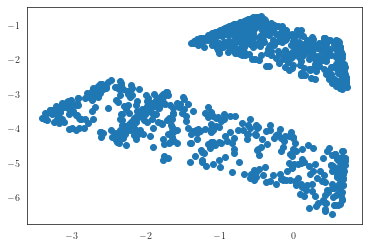

In [3]:
nominal_manager = ModelManager("config/bullseye2d_nominal.json")
nominal_manager.train()
nominal_manager.load_model(checkpoint_file="model_best.pth")

nominal_mapping = torch.cat([nominal_manager.model(x)[2].detach() for x,y in nominal_manager.data_loader]).cpu().numpy()[:,:,0]

plt.figure()
plt.scatter(nominal_mapping[:,0], nominal_mapping[:,1])
plt.show()

### 2. learn mapping using the proposed information efficiency regularization

Validation performance didn't improve for 10 epochs. Training stops.


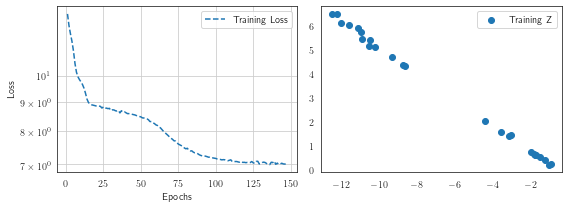

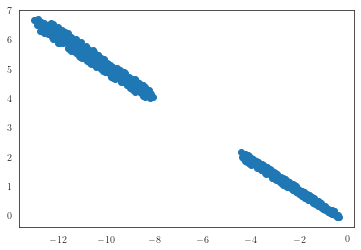

In [4]:
proposed_manager = ModelManager("config/bullseye2d_regularized.json")
proposed_manager.train()
proposed_manager.load_model(checkpoint_file="model_best.pth")

proposed_mapping = torch.cat([proposed_manager.model(x)[2].detach() for x,y in proposed_manager.data_loader]).cpu().numpy()[:,:,0]
plt.figure()
plt.scatter(proposed_mapping[:,0], proposed_mapping[:,1])
plt.show()

## Compare performance of k-NN estimator

In [5]:
from pycit.estimators import ksg_mi

x_data = []
y_data = []
for x,y in proposed_manager.data_loader:
    x_data.append(x)
    y_data.append(y)

x_data = torch.cat(x_data)
y_data = torch.cat(y_data)
r_data = np.linalg.norm(x_data, axis=1)

nominal_mapping = nominal_manager.model(x_data)[2].detach()
proposed_mapping = proposed_manager.model(x_data)[2].detach()

x_data = x_data.cpu().numpy()[:,:,0]
y_data = y_data.cpu().numpy()[:,0]
nominal_mapping = nominal_mapping.cpu().numpy()[:,:,0]
proposed_mapping = proposed_mapping.cpu().numpy()[:,:,0]

# perform knn estimates
true_mi = datagen.ground_truth
est_base = ksg_mi(x_data, y_data)
est_optimal = ksg_mi(r_data, y_data)
est_nominal_mapping = ksg_mi(nominal_mapping, y_data)
est_proposed_mapping = ksg_mi(proposed_mapping, y_data)

print("True MI:", true_mi)
print("Estimated using samples of magnitude of X:", est_optimal)
print("Estimated using regularized mapping:", est_proposed_mapping)
print("Estimated using nominal mapping:", est_nominal_mapping)
print("Estimated using original samples of X:", est_base)

True MI: 1.504
Estimated using samples of magnitude of X: 1.4487437467321982
Estimated using regularized mapping: 1.333525746706255
Estimated using nominal mapping: 1.2833311056693084
Estimated using original samples of X: 1.1316185211379644
